# Reconstructions.ipynb

### Given Bilby parameter estimation results, plot reconstructions using the surrogate model

Maria Okounkova (mokounkova@flatironinstitute.org)

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from gwpy.timeseries import TimeSeries
from pycbc.detector import Detector
import bilby
from pesummary.io import read
from math import pi
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline
import lal
import lalsimulation as lalsim
import pycbc
from pycbc.filter.matchedfilter import overlap
from scipy.optimize import minimize_scalar
from ipynb.fs.full.Auxiliary import ReadExtrapolatedModes, EvaluateSurrogate, SubtractPeakTime, dt_eval, df_eval, \
                                    PadAndProject, ProjectToDetectors, EllinKm, ComputeSNR, ComputeMultiDetectorSNR, \
                                    ComputeMultiDetectorOverlap, ComputeOverlap
import gwsurrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:733: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_coorb'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:691: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data['EI_basis'] = h5_group['EIBasis'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:692: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data['nodeIndices'] = h5_group['nodeIndices'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:694: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  for i in range(len(data['nodeIndices']))]
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/pre

### Methods for parameter conversions -- masses, spins, inclination

In [7]:
def EffectiveSpin(params_dict):
    """ Compute effective spin given a parameter dictionary """
    m_1 = params_dict['m_1']
    m_2 = params_dict['m_2']
    a_1 = params_dict['a_1'][2] ## grab z component of spin
    a_2 = params_dict['a_2'][2]
    return (a_1/m_1 + a_2/m_2)/(m_1 + m_2)

def MassParameters(BilbyRes):
    """ Compute individual masses and total mass given bilby result """
    q = 1.0/BilbyRes['mass_ratio']
    chirp = BilbyRes['chirp_mass']
    mass = chirp * (q/(1+q)**2)**(-3/5)
    m_2 = mass / (1 + q)
    m_1 = q*m_2
    return m_1, m_2, mass

def change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1,
                           m2, f_ref, phi_orb=0.):
    """ Change spin convention for Bilby / lal quantities to surrogate model quantities """
    iota, S1x, S1y, S1z, S2x, S2y, S2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
                                             theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2,
                                             m1*lal.MSUN_SI, m2*lal.MSUN_SI, f_ref, phi_orb)
    spin1 = [S1x, S1y, S1z]
    spin2 = [S2x, S2y, S2z]
    return spin1, spin2, iota

def Compute_Spins(bilby_result):
    """ Given a bilby result, compute chi_1 and chi_2, as well as the inclination angle in the form 
        to be passed to a surrogate model """
    
    theta_jn = bilby_result['theta_jn']
    phi_jl = bilby_result['phi_jl']
    tilt1 = bilby_result['tilt_1']
    tilt2 = bilby_result['tilt_2']
    phi12 = bilby_result['phi_12']
    a1 = bilby_result['a_1']
    a2 = bilby_result['a_2']
    m1, m2, mass = MassParameters(bilby_result)
    phi_orb = bilby_result['phase'] ## phase of coalescence at some fiducial time 
    f_ref = 25 ## for now
    spin1, spin2, iota = change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1,
                           m2, f_ref, phi_orb)
    return spin1, spin2, iota

### Methods to read waveform from frames files and read injected parameters

In [8]:
def GetFramesData(p):
    
    det = 'H1'
    sH = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    
    det = 'L1'
    sL = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tL = np.array(sH.times)
    
    return tH, sH, tL, sL

def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Methods for reading Bilby parameter estimation results

In [31]:
def GetBilbyParameters(p):
    """ Obtain max likelihood Bilby parameters given what the Bilby Slack said """

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    maxL_ind = np.argmax(result.posterior['log_likelihood'])
    maxL_point = result.posterior.iloc[maxL_ind]
    maxP_ind = np.argmax(result.posterior['log_likelihood'] + result.posterior['log_prior'])
    maxP_point = result.posterior.iloc[maxP_ind]
    
    ## Should I do maxP or maxL
    return maxP_point

def GetMultipleBilbyParameters(p, n_points):
    """ Obtain max likelihood Bilby parameters given what the Bilby Slack said """

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    result_points = []
    N = len(result.posterior['log_likelihood'])
    index_arr = np.linspace(int(0.1*N), N - 1, num = n_points, dtype = int)
    print(N, index_arr)
    
    for index in index_arr:
        point = result.posterior.iloc[index]
        result_points.append(point)

    return result_points

def GetBilbyDict(BilbyRes):
    """ Convert a Bilby max likelihood result into a dictionary of parameters 
        that we can pass into the surrogate model """
    
    BilbyDict = {}
    BilbyDict['dt'] = 1.0/2048.
    
    ## Reciprocal of the mass ratio 
    q = 1.0/BilbyRes['mass_ratio']
    BilbyDict['q'] = q
    
    m_1, m_2, mass = MassParameters(BilbyRes)
    BilbyDict['mass'] = mass
    BilbyDict['m_1'] = m_1
    BilbyDict['m_2'] = m_2
    
    BilbyDict['dist_mpc'] = BilbyRes['luminosity_distance'] 
    BilbyDict['f_low'] = 0.0
    BilbyDict['phi'] = BilbyRes['phase'] ## phase of coalescence (at some fiducial time)
    
    ## Spin computations
    chi_1, chi_2, theta = Compute_Spins(BilbyRes)

    BilbyDict['a_1'] = chi_1
    BilbyDict['a_2'] = chi_2
    chi_eff = EffectiveSpin(BilbyDict)
    BilbyDict['chi_eff'] = chi_eff
    
    BilbyDict['theta'] = theta ## Theta from the spin computation conventions
    
    BilbyDict['ra'] = BilbyRes['ra']
    BilbyDict['dec'] = BilbyRes['dec']
    BilbyDict['t_gps'] = BilbyRes['geocent_time']
    BilbyDict['pol'] = BilbyRes['psi'] ## polarization (angle on the sky of the pericenter wrt to interferometer -- degenerate for circular orbits
    
    return BilbyDict


### Method for optimizing the phase between the injected waveform and the reconstructed surrogate model

In [5]:
def OptimizePhase(timeH, strainH, timeL, strainL, param_dict):
    """ Given a time and a strain array in each detector that we want to compare against, and a dictionary of parameters, 
        iterate over possible phases for the surrogate in order to produce the phase with the largest
        overlap """
    
    def f(x):
        surrogate_dict = param_dict
        surrogate_dict['phi'] = x
        time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(sur, surrogate_dict)
        timeH_sur, strainH_sur, timeL_sur, strainL_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, surrogate_dict)

        #ov = ComputeDetectorOverlap(timeH, strainH, timeL, strainL, \
        #                        timeH_sur, strainH_sur, timeL_sur, strainL_sur)
        ov = ComputeOverlap(timeH, strainH, timeH_sur, strainH_sur)
    
        ## 1 minus the overlap since we're doing minimization
        return 1.0 - ov
    
    ## iterate from zero to 2 * pi
    res = minimize_scalar(f, bounds=(0, 2*pi), method = 'bounded')
    print(res.x)
    return(res.x)

### Method for doing a full Bilby waveform reconstruction

In [5]:
def BilbyReconstruction(p, timeH, strainH, timeL, strainL, truth_dict, optimize_phase = True):
    """ Reconstruct Bilby waveforms from bilby run located in directory p, 
        where timeH, strainH, etc correspond
        to the injected times and strains, and truth dict corresponds to the 
        injected parameters. 
        If optimize_phase = True, then change the phase of the surrogate
        waveform to agree with the Bilby waveform """

    ## Read in bilby parameters
    bilby_result = GetBilbyParameters(p)
    bilby_dict = GetBilbyDict(bilby_result)
    bilby_dict['pol'] = truth_dict['pol'] ## because degenerate for circular orbits
    bilby_dict['t_gps'] = truth_dict['t_gps']
    bilby_dict['peak_time_in_segment'] = truth_dict['peak_time_in_segment']
    bilby_dict['segment_length'] = truth_dict['segment_length']
    
    ## Optimize the phase
    if optimize_phase:
        print('opt phase')
        phi_opt = OptimizePhase(timeH, strainH, timeL, strainL, bilby_dict)
        bilby_dict['phi'] = phi_opt
    time_bil, h_plus_bil, h_cross_bil, amp_bil = EvaluateSurrogate(sur, bilby_dict)   
    timeH_bil, strainH_bil, timeL_bil, strainL_bil = PadAndProject(time_bil, h_plus_bil, h_cross_bil, bilby_dict)
    
    ## Compute the overlap
    ov = ComputeMultiDetectorOverlap(timeH, strainH, timeL, strainL, \
                                timeH_bil, strainH_bil, timeL_bil, strainL_bil)
    print(p, ov)
 
    return timeH_bil, strainH_bil, timeL_bil, strainL_bil, ov

### Perform and plot reconstructions

In [7]:
def PlotReconstructions():

    ## Injected waveform 
    p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Test_FullSearchNoTiltNoSkyLoc_35_0p99'
    truth_dict = GetInjectedParameters(p)
    timeH, strainH, timeL, strainL = GetFramesData(p)
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    p = base_dir + 'Test_FullSearchNoTiltNoSkyLoc_35_0p99'
    tH1, sH1, tL1, sL1, ov1 = BilbyReconstruction(p, timeH, strainH, timeL, strainL, truth_dict)

    #p = base_dir + 'Test_FullSearchNoTilt_35_0p99'
    #tH2, sH2, tL2, sL2, ov2 = BilbyReconstruction(p, timeH, strainH, timeL, strainL, truth_dict)

    #p = base_dir + 'Test_FullSearch_35_0p99'
    #tH3, sH3, tL3, sL3, ov3 = BilbyReconstruction(p, timeH, strainH, timeL, strainL, truth_dict)
    
    plt.figure(figsize=(16,8))

    plt.plot(tH1, sH1, lw = 1.0, color = 'blue', label = r'All parameter except tilt and sky location search, $f_\mathrm{min} = 35$, $a_\mathrm{max} = 0.99$')
    #plt.plot(tH2, sH2, lw = 1.0, color = 'red', label = r'All parameter except tilt, $f_\mathrm{min} = 35$, $a_\mathrm{max} = 0.99$')
    #plt.plot(tH3, sH3, lw = 1.0, color = 'pink', label = 'All parameter search, $f_\mathrm{min} = 35$, $a_\mathrm{max} = 0.99$')
    plt.plot(timeH, strainH, lw = 1.0, color = 'black', label = 'GR Injection')

    plt.xlim(-0.15 + truth_dict['t_gps'], 0.033 + truth_dict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=18, loc = 'lower left', frameon=True)
    plt.grid()
    plt.tight_layout()
    plt.savefig('BilbyReconstructions.pdf')
    plt.show()


/home/maria.okounkova/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)
ipynb.fs.full.Auxiliary:360: RuntimeWarning: invalid value encountered in sqrt


2.423522546916441
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Test_FullSearchNoTiltNoSkyLoc_35_0p99 0.9807478094318159


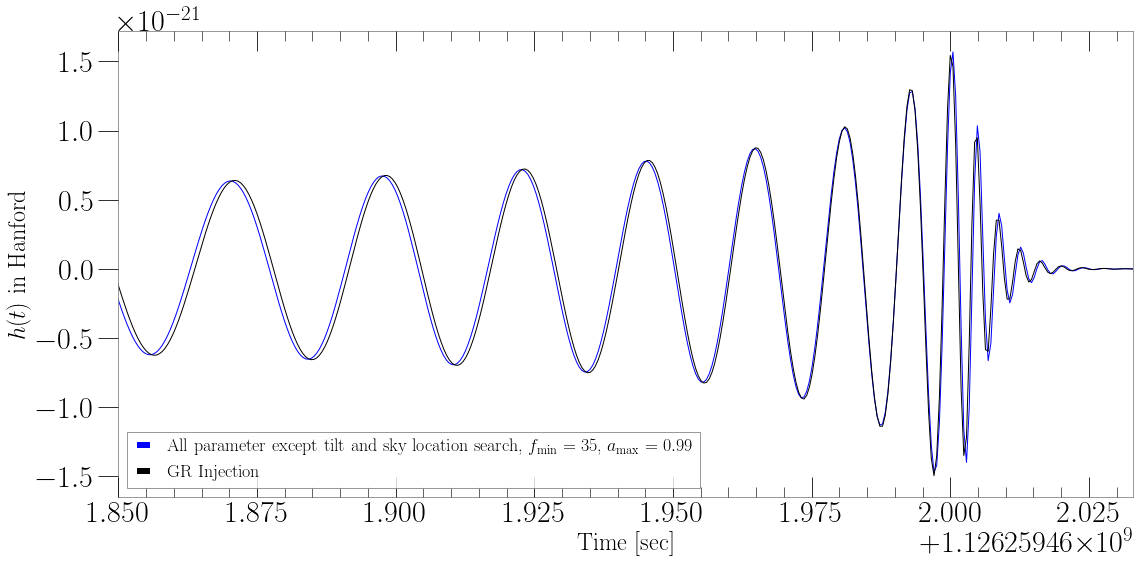

In [8]:
PlotReconstructions()

## Plot multiple waveform reconstructions

36670 [ 3667  5042  6417  7792  9167 10542 11917 13292 14667 16042
 17417 18792 20168 21543 22918 24293 25668 27043 28418 29793
 31168 32543 33918 35293 36669]


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.8589 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))


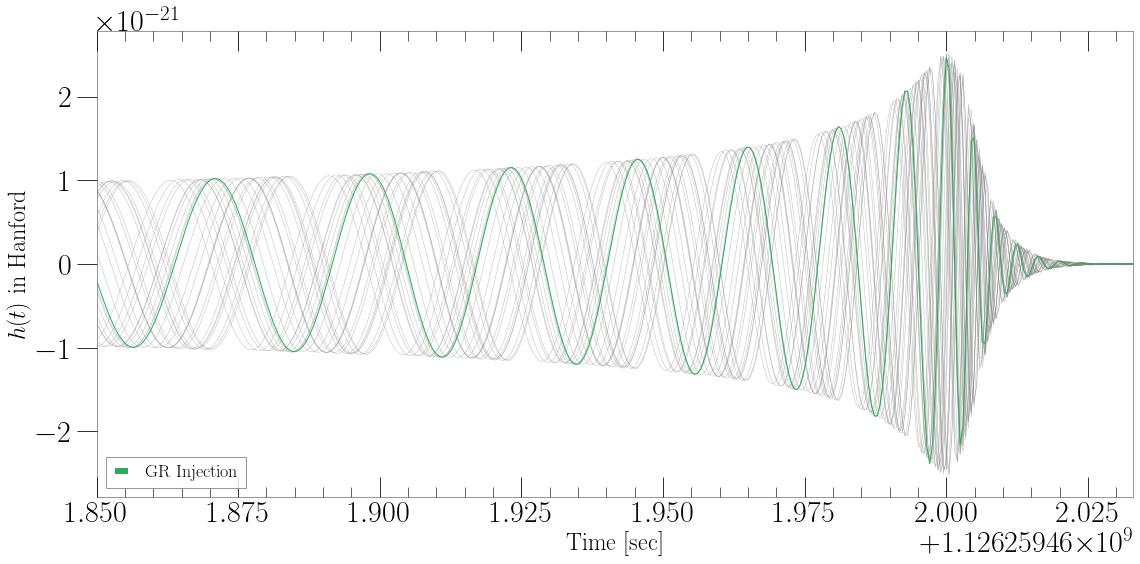

In [35]:
def PlotMultipleReconstructions():

    plt.figure(figsize=(16,8))
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    p = base_dir + 'dCS_0p0_125' # 'Test_FullSearchNoTiltNoSkyLoc_35_0p99'
    
    ## Injected waveform 
    truth_dict = GetInjectedParameters(p)
    timeH, strainH, timeL, strainL = GetFramesData(p)
    
    ## Plot multiple reconstructed waveforms
    bilby_results = GetMultipleBilbyParameters(p, 25)
    
    for bilby_result in bilby_results:
        
        bilby_dict = GetBilbyDict(bilby_result)
        bilby_dict['pol'] = truth_dict['pol'] ## because degenerate for circular orbits
        bilby_dict['t_gps'] = truth_dict['t_gps']
        bilby_dict['peak_time_in_segment'] = truth_dict['peak_time_in_segment']
        bilby_dict['segment_length'] = truth_dict['segment_length']
    
        time_bil, h_plus_bil, h_cross_bil, amp_bil = EvaluateSurrogate(sur, bilby_dict)   
        timeH_bil, strainH_bil, timeL_bil, strainL_bil = PadAndProject(time_bil, h_plus_bil, h_cross_bil, bilby_dict)

        plt.plot(timeH_bil, strainH_bil, lw = 0.5, color = 'gray', alpha = 0.5)

    ## Plot GR waveform   
    plt.plot(timeH, strainH, lw = 3.0, color = '#1ae863', label = 'GR Injection')
    
    plt.xlim(-0.15 + truth_dict['t_gps'], 0.033 + truth_dict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=18, loc = 'lower left', frameon=True)
    plt.grid()
    plt.tight_layout()
    plt.savefig('BilbyMultipleReconstructions.pdf')
    plt.show()

PlotMultipleReconstructions()